In [1]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
from qiskit_nature.drivers.second_quantization import PySCFDriver
from qiskit_nature.problems.second_quantization.electronic import ElectronicStructureProblem

from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import JordanWignerMapper
from qiskit_nature.circuit.library import HartreeFock, UCC
from qiskit.algorithms.optimizers import COBYLA, CG, SLSQP, L_BFGS_B
from qiskit.algorithms import VQE
from qiskit_nature.algorithms.ground_state_solvers.minimum_eigensolver_factories import NumPyMinimumEigensolverFactory
from qiskit import Aer
import numpy as np 
from qiskit_nature.algorithms.ground_state_solvers import GroundStateEigensolver
from qiskit.circuit import Parameter, QuantumCircuit, QuantumRegister

# import logging
# logging.basicConfig(filename="H2_1.0.log", level=logging.INFO)
# logger=logging.getLogger()
# logger.setLevel(logging.DEBUG)

/tmp/ipykernel_256/2541035671.py:9: NatureDeprecationWarning: The qiskit_nature.algorithms.excited_state_solvers package is deprecated as of version 0.5.0 and will be removed no sooner than 3 months after the release. Instead use the qiskit_nature.second_q.algorithms.excited_state_solvers package.
  from qiskit_nature.algorithms.ground_state_solvers.minimum_eigensolver_factories import NumPyMinimumEigensolverFactory
/tmp/ipykernel_256/2541035671.py:9: NatureDeprecationWarning: The qiskit_nature.algorithms.pes_sampler package is deprecated as of version 0.5.0 and will be removed no sooner than 3 months after the release . Please refer to 'https://github.com/Qiskit/qiskit-nature/issues/750' for additional information regarding 'extrapolators'.
  from qiskit_nature.algorithms.ground_state_solvers.minimum_eigensolver_factories import NumPyMinimumEigensolverFactory


# WORK THIS IN AN OFFLINE MACHINE BECAUSE ONLINE (JUPYTER) NOTEBOOK IS SLOW

In [ ]:
coord = 'H 0.0 0.0 0.0; H 0.0 0.0 0.735'
driver = PySCFDriver(atom=coord, charge=0, spin=0, basis='sto3g')
es_problem = ElectronicStructureProblem(driver)

# obtaining qubit Hamiltonian
mapper = JordanWignerMapper()
converter = QubitConverter(mapper=mapper, two_qubit_reduction=False)
second_q_op = es_problem.second_q_ops()
print(second_q_op['ElectronicEnergy'])
qubit_op = converter.convert(second_q_op['ElectronicEnergy'])
print(qubit_op)

es_particle_number = es_problem.grouped_property_transformed.get_property('ParticleNumber')
num_particles = (es_particle_number.num_alpha, es_particle_number.num_beta)
num_spin_orbitals = es_particle_number.num_spin_orbitals
es_energy = es_problem.grouped_property_transformed.get_property('ElectronicEnergy')
#print(es_energy.electronic_energy)
nuclear_repulsion_energy = es_energy.nuclear_repulsion_energy
shift = nuclear_repulsion_energy
print('Number Of Particles: ',num_particles)
print('Number of Spin Orbitals: ', num_spin_orbitals)
print('Nuclear Repulsion Energy: ', nuclear_repulsion_energy)


# initialization of state
init_state = HartreeFock(num_spin_orbitals, num_particles, converter)

#optimizer = L_BFGS_B(maxfun=200000,maxiter=10000)
backend = Aer.get_backend('statevector_simulator')

#Create dummy parametrized circuit for HF calculation
theta = Parameter('a')
n = qubit_op.num_qubits
qc = QuantumCircuit(qubit_op.num_qubits)
qc.rz(theta*0,0)
ansatz = qc
ansatz.compose(init_state, front=True, inplace=True)

#Pass it through VQE
algorithm = VQE(ansatz,quantum_instance=backend)
result = algorithm.compute_minimum_eigenvalue(qubit_op).eigenvalue
print('HF Energy is',np.real(result)+shift)

# Variational ansatz formation
var_form = UCC(num_particles=num_particles,num_spin_orbitals=num_spin_orbitals, excitations='sd', initial_state=init_state, qubit_converter=converter)
excitation_list = var_form._get_excitation_list()
print('no of parameters',var_form.num_parameters)
print('Excitation list is',excitation_list)
circuit = var_form.decompose() #.decompose().decompose()
print(circuit)


backend = Aer.get_backend('statevector_simulator')

optimizer = COBYLA(maxiter=10000)

counts = list()
values = list()
def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)

#VQE optimization
vqe1 = VQE(var_form, optimizer=optimizer, callback = store_intermediate_result, quantum_instance=backend)
vqe_result = vqe1.compute_minimum_eigenvalue(qubit_op)
E1 = np.real(vqe_result.eigenvalue)+shift
print('VQE Optimized UCCSD Energy is',E1)

# NumPyMinimumEigensolver (FCI Energy)
solver = NumPyMinimumEigensolverFactory()
calc = GroundStateEigensolver(converter, solver)
numpy_result = calc.solve(es_problem)
exact_energy = np.real(numpy_result.eigenenergies[0]) + shift
print('EXACT ENERGY: ', exact_energy)

# plot the convergence pattern
import matplotlib.pyplot as plt

plt.plot(counts,values,c='r',linewidth=2,label='COBYLA')
plt.legend()
plt.grid()
#plt.show()

#plt.savefig('H2_Con.png',dpi=600)
plt.show()

In [10]:
import matplotlib.pyplot as plt

def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)

Finding for H 0.0 0.0 0.0; H 0.0 0.0 0.1
Finding for H 0.0 0.0 0.0; H 0.0 0.0 0.42222222222222217
Finding for H 0.0 0.0 0.0; H 0.0 0.0 0.7444444444444444
Finding for H 0.0 0.0 0.0; H 0.0 0.0 1.0666666666666667
Finding for H 0.0 0.0 0.0; H 0.0 0.0 1.3888888888888888
Finding for H 0.0 0.0 0.0; H 0.0 0.0 1.711111111111111
Finding for H 0.0 0.0 0.0; H 0.0 0.0 2.033333333333333
Finding for H 0.0 0.0 0.0; H 0.0 0.0 2.3555555555555556
Finding for H 0.0 0.0 0.0; H 0.0 0.0 2.6777777777777776
Finding for H 0.0 0.0 0.0; H 0.0 0.0 3.0


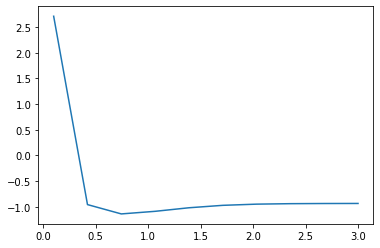

In [ ]:
h = np.linspace(0.1, 3, 10)
energy = []

for i in h:
    coord = f'H 0.0 0.0 0.0; H 0.0 0.0 {i}'
    print(f"Finding for {coord}")
    driver = PySCFDriver(atom=coord, charge=0, spin=0, basis='sto3g')
    es_problem = ElectronicStructureProblem(driver)

    # obtaining qubit Hamiltonian
    mapper = JordanWignerMapper()
    converter = QubitConverter(mapper=mapper, two_qubit_reduction=False)
    second_q_op = es_problem.second_q_ops()
    # print(second_q_op['ElectronicEnergy'])
    qubit_op = converter.convert(second_q_op['ElectronicEnergy'])
    # print(qubit_op)

    es_particle_number = es_problem.grouped_property_transformed.get_property('ParticleNumber')
    num_particles = (es_particle_number.num_alpha, es_particle_number.num_beta)
    num_spin_orbitals = es_particle_number.num_spin_orbitals
    es_energy = es_problem.grouped_property_transformed.get_property('ElectronicEnergy')
    #print(es_energy.electronic_energy)
    nuclear_repulsion_energy = es_energy.nuclear_repulsion_energy
    shift = nuclear_repulsion_energy
    # print('Number Of Particles: ',num_particles)
    # print('Number of Spin Orbitals: ', num_spin_orbitals)
    # print('Nuclear Repulsion Energy: ', nuclear_repulsion_energy)


    # initialization of state
    init_state = HartreeFock(num_spin_orbitals, num_particles, converter)

    #optimizer = L_BFGS_B(maxfun=200000,maxiter=10000)
    backend = Aer.get_backend('statevector_simulator')

    #Create dummy parametrized circuit for HF calculation
    theta = Parameter('a')
    n = qubit_op.num_qubits
    qc = QuantumCircuit(qubit_op.num_qubits)
    qc.rz(theta*0,0)
    ansatz = qc
    ansatz.compose(init_state, front=True, inplace=True)

    #Pass it through VQE
    algorithm = VQE(ansatz,quantum_instance=backend)
    result = algorithm.compute_minimum_eigenvalue(qubit_op).eigenvalue
    # print('HF Energy is',np.real(result)+shift)

    # Variational ansatz formation
    var_form = UCC(num_particles=num_particles,num_spin_orbitals=num_spin_orbitals, excitations='sd', initial_state=init_state, qubit_converter=converter)
    excitation_list = var_form._get_excitation_list()
    # print('no of parameters',var_form.num_parameters)
    # print('Excitation list is',excitation_list)
    circuit = var_form.decompose() #.decompose().decompose()
    # print(circuit)


    backend = Aer.get_backend('statevector_simulator')

    optimizer = COBYLA(maxiter=10000)

    counts = list()
    values = list()
    
    #VQE optimization
    vqe1 = VQE(var_form, optimizer=optimizer, callback = store_intermediate_result, quantum_instance=backend)
    vqe_result = vqe1.compute_minimum_eigenvalue(qubit_op)
    E1 = np.real(vqe_result.eigenvalue)+shift
    # print('VQE Optimized UCCSD Energy is',E1)

    # NumPyMinimumEigensolver (FCI Energy)
    solver = NumPyMinimumEigensolverFactory()
    calc = GroundStateEigensolver(converter, solver)
    numpy_result = calc.solve(es_problem)
    exact_energy = np.real(numpy_result.eigenenergies[0]) + shift
    
    energy.append(exact_energy)

# print(zip(h, exact_energy))
plt.plot(h, energy)